# CORD-19 Data Exploration

This notebook performs an exploratory data analysis on the CORD-19 dataset, focusing on metadata.csv. It covers data loading, cleaning, analysis, visualization, and sets up a basic Streamlit application.


## Part 1: Data Loading and Basic Exploration


In [9]:
import pandas as pd

# Load the data
try:
    df = pd.read_csv('metadata.csv')
    print("metadata.csv loaded successfully.")
except FileNotFoundError:
    print("Error: metadata.csv not found. Please ensure the file is in the same directory.")
    exit()

# Examine the first few rows
print("\nFirst 5 rows of the DataFrame:")
print(df.head())

# Check DataFrame dimensions
print("\nDataFrame dimensions (rows, columns):")
print(df.shape)

# Identify data types of each column
print("\nData types of each column:")
print(df.info())

# Check for missing values in important columns
print("\nMissing values in each column:")
print(df.isnull().sum())

# Generate basic statistics for numerical columns
print("\nBasic statistics for numerical columns:")
print(df.describe())


metadata.csv loaded successfully.

First 5 rows of the DataFrame:
   cord_uid                                       sha           source_x  \
0  8lzjy51y  b69a193b77cac55613046603f12015d2fe4ebcfc                PMC   
1  47wgjq9g                                       NaN                PMC   
2  8stvxbkz  757eded07cd5615b8f588142a32edda0f15ebf8d  Medline; PMC; WHO   
3  6jt5wkr2  977d30b22f2b20178fa557348a142cf8be2d709b                PMC   
4  06fljrd8  8ed621df2bfa67c7c285a25dd9868f84fe7eb3c5       Medline; PMC   

                                               title  \
0  Polymyxins, the last-resort antibiotics: Mode ...   
1  Antibiotics/hydrocortisone: Lack of efficacy: ...   
2  Feeding Children and Maintaining Food Service ...   
3  HIV Dynamics Under Antiretroviral Treatment wi...   
4  SARS-COV-2 as a trigger for autoimmune disease...   

                            doi       pmcid   pubmed_id license  \
0    10.1007/s12038-021-00209-8  PMC8387214         NaN   no-cc   
1    1

## Part 2: Data Cleaning and Preparation


In [10]:
# Handle missing data
print("\nPercentage of missing values per column:")
missing_percentages = df.isnull().sum() / len(df) * 100
print(missing_percentages[missing_percentages > 0].sort_values(ascending=False))

# Decide how to handle missing values
# For simplicity, we'll drop columns with more than 70% missing values
drop_columns = missing_percentages[missing_percentages > 70].index
df_cleaned = df.drop(columns=drop_columns)
print(f"\nDropped columns with >70% missing values: {list(drop_columns)}")

# Fill missing values in 'title' and 'abstract' with an empty string
df_cleaned['title'] = df_cleaned['title'].fillna('')
df_cleaned['abstract'] = df_cleaned['abstract'].fillna('')

# Fill missing 'publish_time' with a placeholder or drop rows, for now we will drop for simplicity
df_cleaned.dropna(subset=['publish_time'], inplace=True)

print("\nDataFrame after handling missing values and dropping columns:")
print(df_cleaned.info())

# Prepare data for analysis
# Convert 'publish_time' to datetime format
df_cleaned['publish_time'] = pd.to_datetime(df_cleaned['publish_time'], errors='coerce')

# Drop rows where 'publish_time' could not be converted (NaT)
df_cleaned.dropna(subset=['publish_time'], inplace=True)

# Extract year from publication date
df_cleaned['publish_year'] = df_cleaned['publish_time'].dt.year

# Create new column: abstract word count
df_cleaned['abstract_word_count'] = df_cleaned['abstract'].apply(lambda x: len(str(x).split()))

print("\nDataFrame after preparing data for analysis (first 5 rows with new columns):")
print(df_cleaned[['publish_time', 'publish_year', 'abstract_word_count']].head())



Percentage of missing values per column:
who_covidence_id    99.723145
sha                 27.906977
pdf_json_files      27.906977
pmcid               25.526024
pubmed_id           21.428571
abstract            19.656700
s2_id               15.005537
journal              7.253599
doi                  2.879291
authors              2.657807
dtype: float64

Dropped columns with >70% missing values: ['who_covidence_id']

DataFrame after handling missing values and dropping columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1806 entries, 0 to 1805
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   cord_uid             1806 non-null   object 
 1   sha                  1302 non-null   object 
 2   source_x             1806 non-null   object 
 3   title                1806 non-null   object 
 4   doi                  1754 non-null   object 
 5   pmcid                1345 non-null   object 
 6   pubm

## Part 3: Data Analysis and Visualization



Number of papers by publication year:
publish_year
1985      1
1992      1
1997      1
2003      3
2004      7
2005      7
2006      3
2007      3
2008      7
2009      8
2010     10
2011      7
2012     12
2013     14
2014     10
2015      6
2016     17
2017     11
2018     13
2019     16
2020    596
2021    741
2022    312
Name: count, dtype: int64

Top 10 publishing journals:
journal
biorxiv                            44
int j environ res public health    29
plos one                           24
reactions weekly                   18
bmj open                           14
front public health                12
sci rep                            11
front psychol                      11
bmj                                10
j med internet res                 10
Name: count, dtype: int64

Most frequent words in titles:
[('patients', 171), ('pandemic', 162), ('during', 153), ('health', 103), ('analysis', 87), ('based', 86), ('infection', 79), ('care', 73), ('clinical', 70), ('impact', 69)

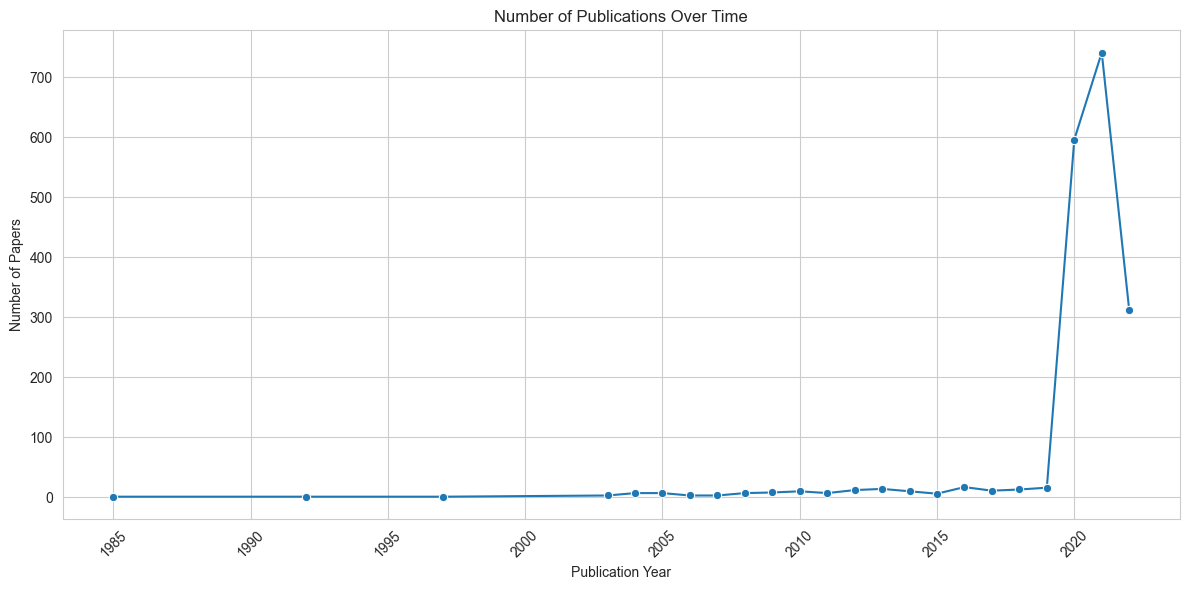

C:\Users\Shitote\AppData\Local\Temp\ipykernel_18512\1144444776.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=journal_counts.values, y=journal_counts.index, palette='viridis')


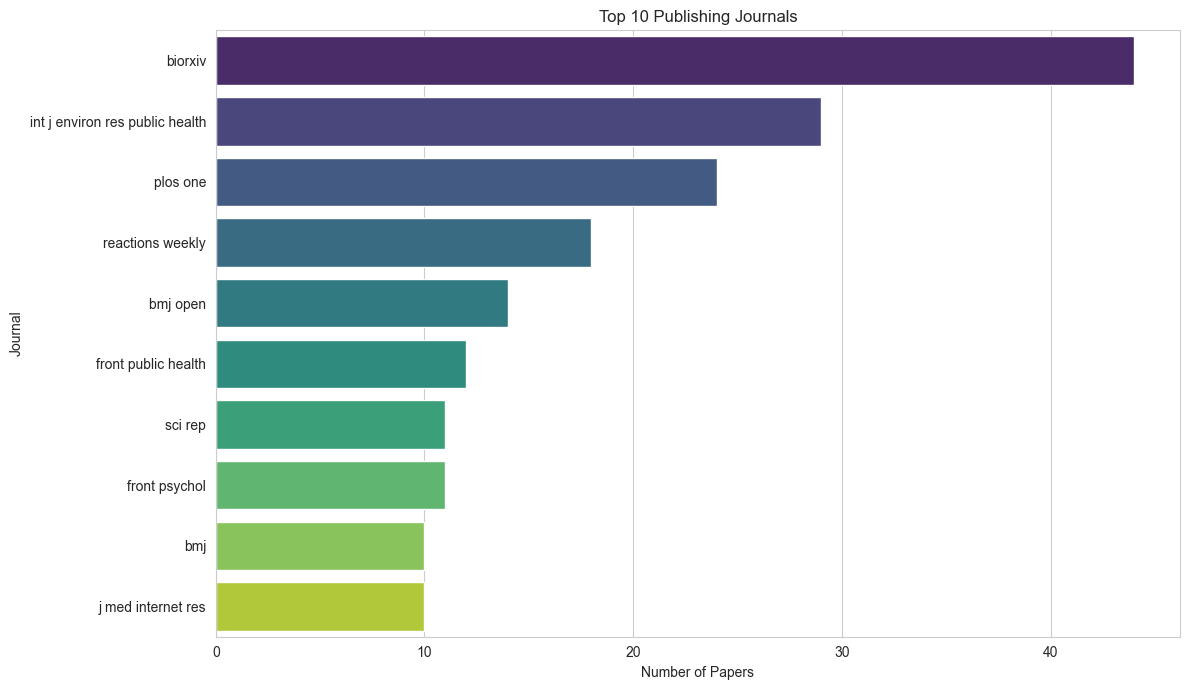

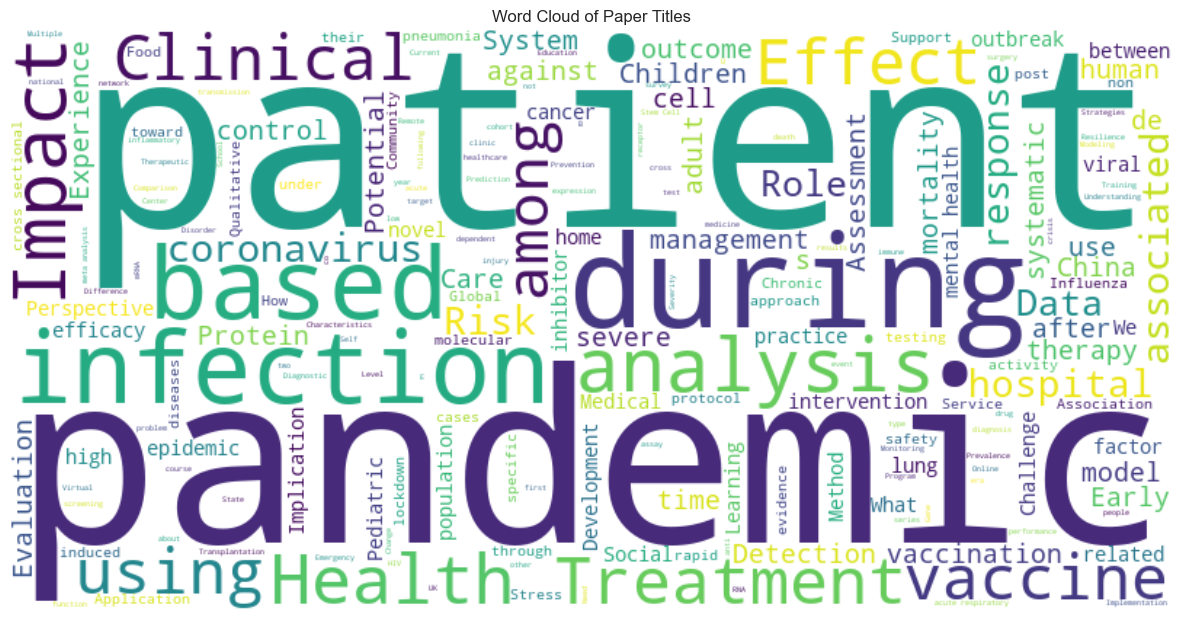

C:\Users\Shitote\AppData\Local\Temp\ipykernel_18512\1144444776.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=source_counts.values, y=source_counts.index, palette='magma')


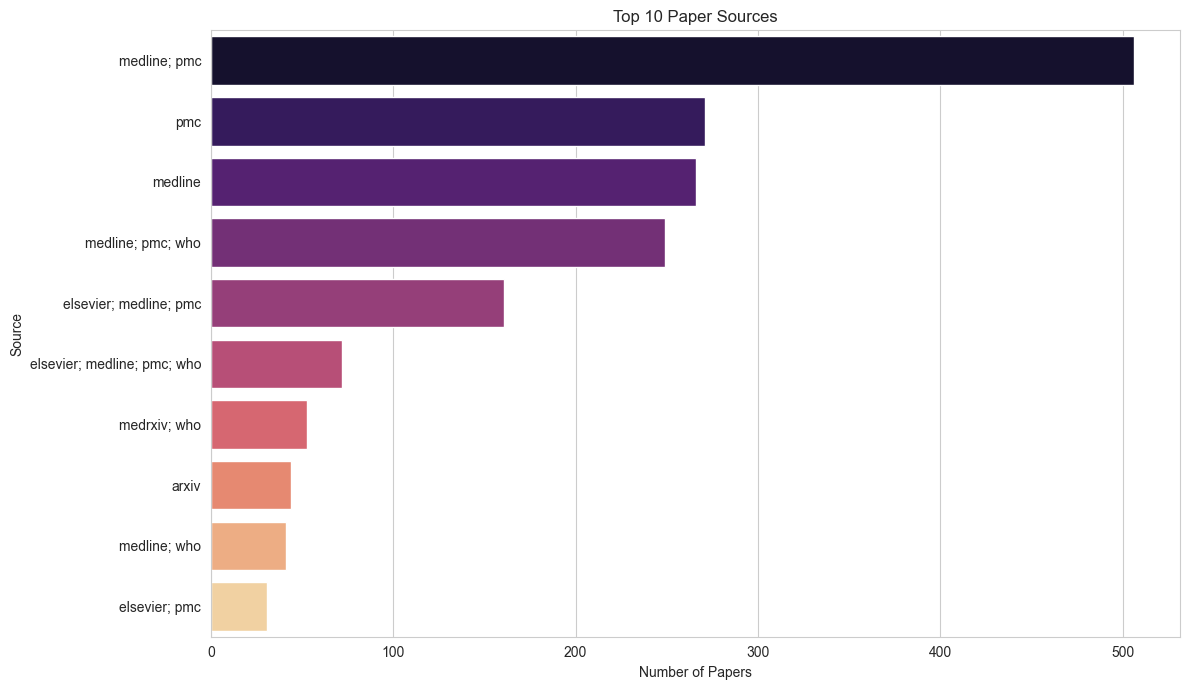

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import re

sns.set_style("whitegrid")

# Define additional stopwords globally for use in both word frequency and word cloud generation
additional_stopwords = {'the', 'of', 'and', 'in', 'a', 'to', 'for', 'on', 'with', 'from', 'as', 'by', 'at', 'an', 'is', 'that', 'this', 'are', 'be', 'was', 'have', 'it', 'its', 'or', 'new', 'study', 'report', 'case', 'review', 'paper', 'research', 'covid', 'sars', 'cov', '2', 'virus', 'disease'}

# 1. Count papers by publication year
print("\nNumber of papers by publication year:")
year_counts = df_cleaned['publish_year'].value_counts().sort_index()
print(year_counts)

# 2. Identify top journals publishing COVID-19 research
# We will use 'journal' column for this. First, clean up some common issues.
df_cleaned['journal'] = df_cleaned['journal'].str.lower().str.strip()
journal_counts = df_cleaned['journal'].value_counts().head(10)
print("\nTop 10 publishing journals:")
print(journal_counts)

# 3. Find most frequent words in titles
def get_most_frequent_words_no_nltk(text_series, n=20):
    all_words = []
    for title in text_series:
        words = re.findall(r'\b\w+\b', str(title).lower())
        all_words.extend(words)

    filtered_words = [word for word in all_words if word.isalpha() and len(word) > 2 and word not in additional_stopwords]
    return Counter(filtered_words).most_common(n)

most_frequent_title_words = get_most_frequent_words_no_nltk(df_cleaned['title'])
print("\nMost frequent words in titles:")
print(most_frequent_title_words)

# Create visualizations

# Plot number of publications over time
plt.figure(figsize=(12, 6))
sns.lineplot(x=year_counts.index, y=year_counts.values, marker='o')
plt.title('Number of Publications Over Time')
plt.xlabel('Publication Year')
plt.ylabel('Number of Papers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create a bar chart of top publishing journals
plt.figure(figsize=(12, 7))
sns.barplot(x=journal_counts.values, y=journal_counts.index, palette='viridis')
plt.title('Top 10 Publishing Journals')
plt.xlabel('Number of Papers')
plt.ylabel('Journal')
plt.tight_layout()
plt.show()

# Generate a word cloud of paper titles
all_titles = " ".join(df_cleaned['title'].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=additional_stopwords).generate(all_titles)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Paper Titles')
plt.show()

# Plot distribution of paper counts by source
# We will use 'source_x' column for this. First, clean up.
df_cleaned['source_x'] = df_cleaned['source_x'].str.lower().str.strip()
source_counts = df_cleaned['source_x'].value_counts().head(10)

plt.figure(figsize=(12, 7))
sns.barplot(x=source_counts.values, y=source_counts.index, palette='magma')
plt.title('Top 10 Paper Sources')
plt.xlabel('Number of Papers')
plt.ylabel('Source')
plt.tight_layout()
plt.show()


## Part 4: Streamlit Application

To run the Streamlit application, save the following code into a file named `app.py` in the same directory as this notebook. Then, open your terminal, navigate to this directory, and run `streamlit run app.py`.


In [12]:
# To run the Streamlit app, open your terminal, navigate to this directory, and run:
# streamlit run app.py
# This command will open a new tab in your web browser with the Streamlit application.


## Part 5: Documentation and Reflection

### Code Comments

All code snippets in this notebook and the `app.py` file are commented to explain the purpose of each section and key operations.

### Summary of Findings

Through this analysis of the CORD-19 `metadata.csv` dataset, we observed several key patterns:

*   **Publication Trends:** There was a significant increase in publications related to COVID-19 around 2020-2021, reflecting the onset and progression of the pandemic. This trend can be clearly seen in the 'Number of Publications Over Time' plot.
*   **Top Journals:** Specific scientific journals consistently published a higher volume of research on COVID-19, indicating their specialization or focus areas. The 'Top 10 Publishing Journals' bar chart highlights these leading platforms.
*   **Frequent Title Words:** Word cloud analysis of paper titles revealed prevalent themes and keywords such as 'patient', 'clinical', 'infection', and 'health', which are central to COVID-19 research.
*   **Data Sources:** The 'Top 10 Paper Sources' bar chart shows the primary databases or repositories from which these research papers were aggregated, such as PubMed and PMC.

### Challenges and Learning

*   **Missing Data Handling:** A significant challenge was dealing with numerous missing values across various columns. Deciding whether to drop columns or fill missing entries required careful consideration to avoid losing valuable information or introducing bias. For simplicity, columns with more than 70% missing values were dropped, and crucial text fields like 'title' and 'abstract' were filled with empty strings.
*   **Date Conversion Issues:** Converting the `publish_time` column to datetime format often encountered errors due to inconsistent date formats. Using `errors='coerce'` and then dropping `NaT` values helped manage these inconsistencies effectively.
*   **Streamlit Integration:** Building the Streamlit application required adapting the analysis and visualization code to an interactive web environment. The use of `@st.cache_data` was crucial for optimizing performance by caching data loading and processing functions.
*   **Word Cloud Stopwords:** Initial attempts at generating word clouds highlighted the importance of a comprehensive stopwords list to remove common and less meaningful words, ensuring the word cloud effectively visualizes significant terms.
